## Smunch User Cluster Analysis

The below analyzes the smunch user base annd attempts to cluster the users into three categories:
* Protien
* Vegetarian
* Vegan

In [1]:
## Initialization and imports
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter

import seaborn as sns

## Changing directory to top folder (All programs run from top)
import os
os.chdir('/Users/nschumacher/docs/galvanize/smunch-user-food-analysis')

## local run sql file
from db.python_db import run_sql_query

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

%matplotlib inline  
%config InlineBackend.figure_format='retina'

## Set random seed
np.random.seed(seed=14)

In [2]:
meal_cat = run_sql_query("SELECT * FROM bi.dish_profiles_static")

q = '''
SELECT
    contact_sfid as user_id,
    ARRAY_AGG(product_sfid) as product_sfids
FROM
    bi.executed_order_employee
WHERE
    order_type = 'single'
GROUP BY
    contact_sfid'''

user_meals_df = run_sql_query(q)

In [3]:
meal_cat.set_index('product_sfid', inplace=True)
meal_cat.sample(3)

,mece_category,is_lc,is_gf,is_lf,type
product_sfid,,,,,
a050N0000124ZwRQAU,Vegan/HC/GF/LF,False,True,True,Vegan
a050N000010WsiXQAS,Animal protein/HC//,False,False,False,Animal protein
a050N0000125yqKQAQ,Animal protein/LC/GF/,True,True,False,Animal protein


In [4]:
user_meals_df.set_index('user_id', inplace=True)
user_meals_df.sample(3)

,product_sfids
user_id,
0030N00002LQpTeQAL,"[a050N00000zZfz0QAC, a050N00000zZg0HQAS, a050N..."
0030N00002PriXQQAZ,"[a050N00000za4nqQAA, a050N000010W5f8QAC]"
0030N00002jEeX3QAK,"[a050N000013tq8eQAA, a050N00000zZg8VQAS, a050N..."


In [5]:
## Dictionary with meal id as key and type as value
meal_dict = meal_cat['type'].to_dict()

## Adding a meal count column so cann drop users with not enough meals
user_meals_df['meal_count'] = user_meals_df['product_sfids'].str.len()

## Drop customers with less than x orders
user_meals_df = user_meals_df[user_meals_df['meal_count'] > 30]

print("Left with {0} users.".format(user_meals_df.shape[0]))

Left with 2449 users.


In [6]:
## Convert meal_ids to their categories
def convert_product_ids(ids, meal_dict):
    categories = []
    for idd in ids:
        if idd in meal_dict.keys():
            categories.append(meal_dict[idd])
    
    counts = Counter(categories)
    return (counts['Vegan'], counts['Vegetarian'], counts['Animal protein'])

user_cat_counts = user_meals_df['product_sfids'].apply(convert_product_ids, args=(meal_dict,))
user_cat_counts = pd.DataFrame(user_cat_counts)

In [7]:
## expand df.tags into its own dataframe
tags = user_cat_counts['product_sfids'].apply(pd.Series)
tags.rename(columns={0:'vegan', 1:'vegetarian', 2:'animal'}, inplace=True)

## This drop drops customers who have never ordered a classified meal
tags.dropna(axis=0, inplace=True)

In [8]:
## Add a total categorized meals column
tags['total'] = tags.sum(axis=1)
tags.sample(10)

,vegan,vegetarian,animal,total
user_id,,,,
0030N00002LQpclQAD,16,13,18,47
0030N00002LQpINQA1,0,0,29,29
0030N00002UyZfaQAF,1,0,3,4
0030N00002WyAm4QAF,10,30,10,50
0030N00002eWJDgQAO,0,3,47,50
0030N00002dkmkRQAQ,4,2,31,37
0030N00002LQqB9QAL,16,23,84,123
0030N00002LQqDsQAL,5,6,25,36
0030N00002LQqMNQA1,23,17,9,49


In [9]:
print("Only meat eaters: {0:2.2f}%".format(np.mean((tags.vegan == 0) & (tags.vegetarian==0))*100))
print("Only Vegan: {0:2.2f}%".format(np.mean((tags.animal == 0) & (tags.vegetarian==0))*100))
print("Vegan or Vegatarian: {0:2.2f}%".format(np.mean((tags.animal == 0))*100))

Only meat eaters: 5.55%
Only Vegan: 2.94%
Vegan or Vegatarian: 8.37%


In [10]:
## Getting frequency of each
cols = ['vegan', 'vegetarian', 'animal']
for col in cols:
    tags[col] = np.round((tags[col] / tags['total']), 3)

tags.head()

,vegan,vegetarian,animal,total
user_id,,,,
0030N00002aHyTcQAK,0.237,0.263,0.500,76
0030N00002aI2XlQAK,0.000,0.106,0.894,66
0030N00002aIjqrQAC,0.000,0.056,0.944,36
0030N00002aIlJAQA0,0.067,0.178,0.756,90
0030N00002b96PwQAI,0.244,0.378,0.378,45


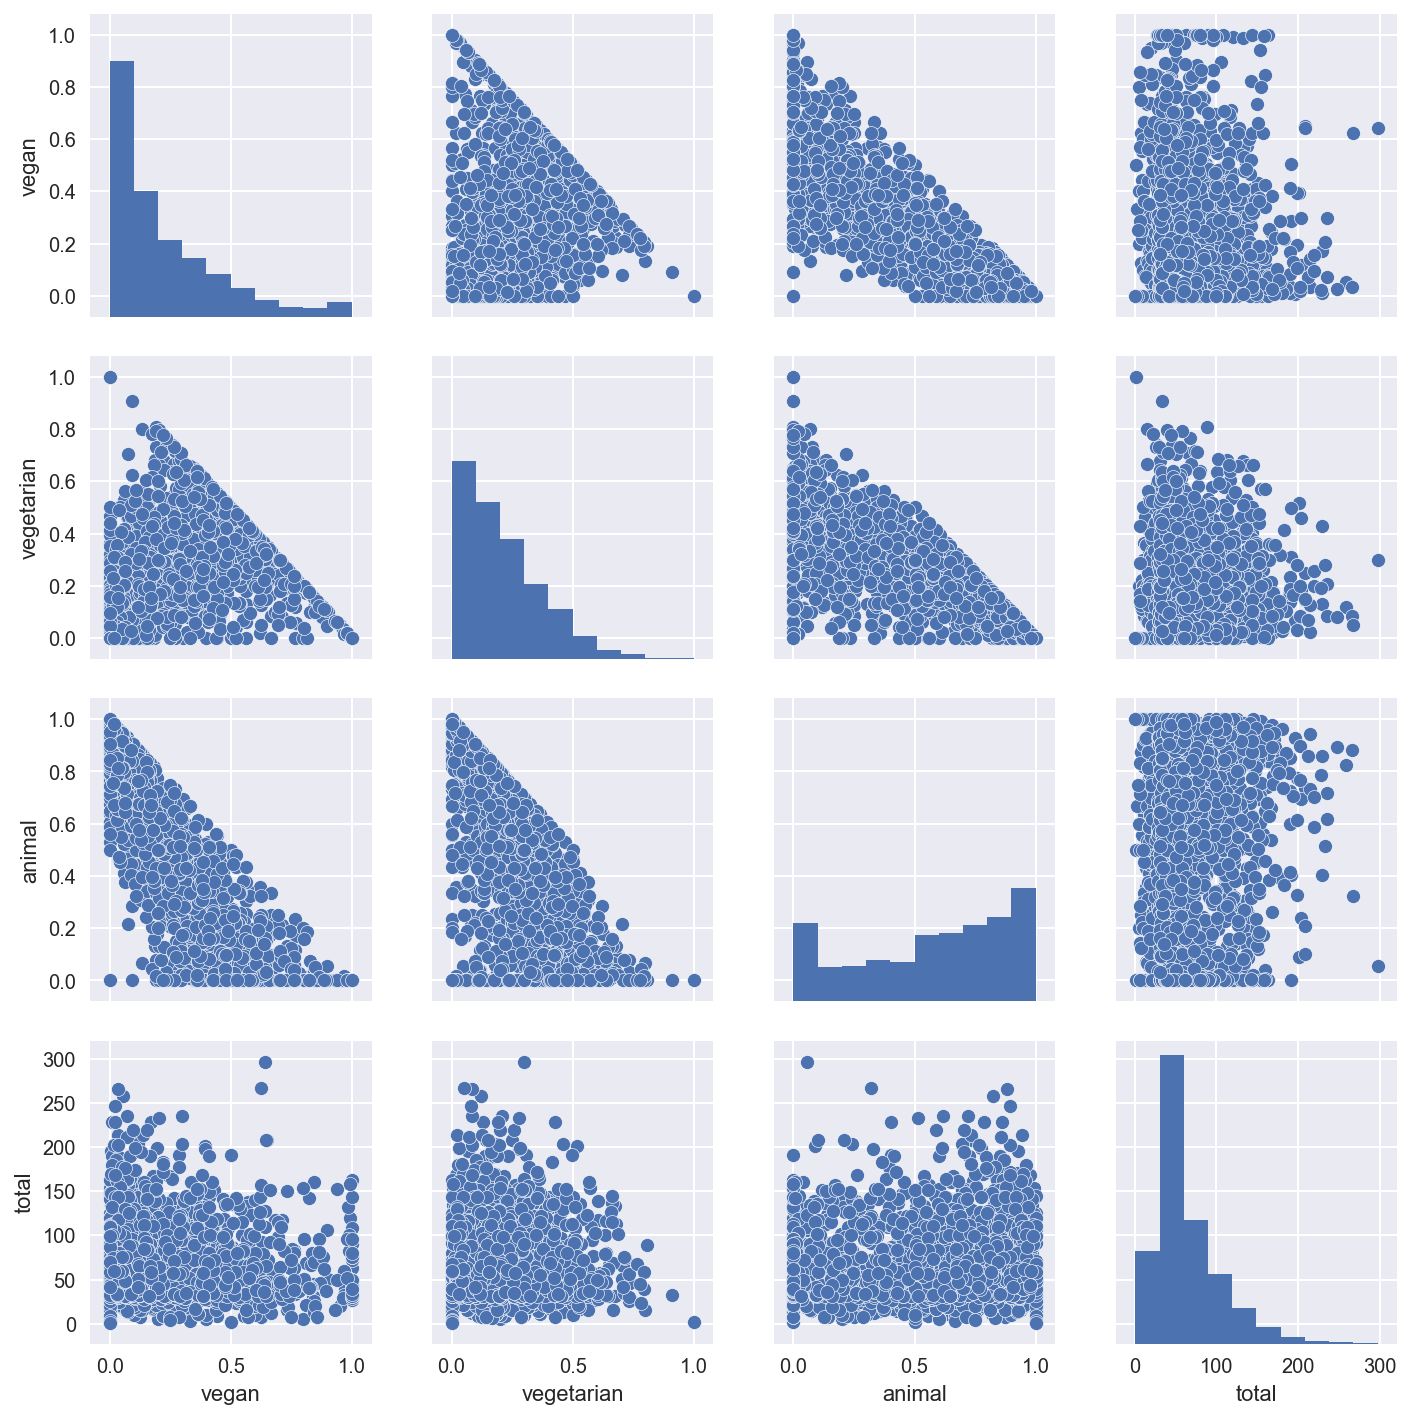

In [11]:
## Seaborn pairplot for inspection
tags.dropna(axis=0, inplace=True)
sns.pairplot(tags)

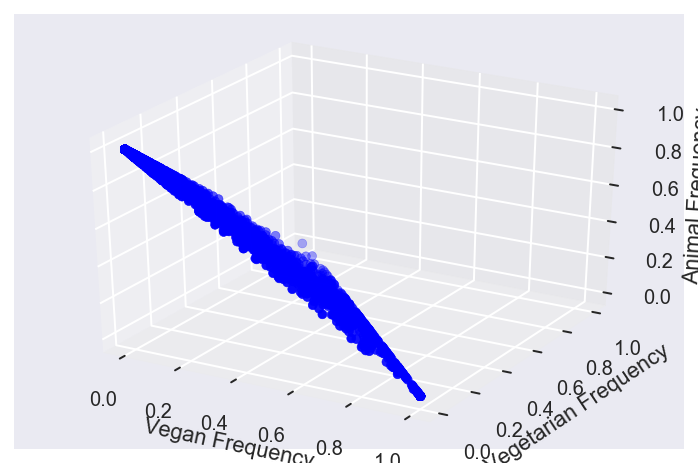

In [12]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tags.vegan, tags.vegetarian, tags.animal, c='b', marker='o')

ax.set_xlabel('Vegan Frequency')
ax.set_ylabel('Vegetarian Frequency')
ax.set_zlabel('Animal Frequency')
plt.show()